This is a follow-along notebook of [Document Analysis Graph](https://colab.research.google.com/github/huggingface/agents-course/blob/main/notebooks/unit2/langgraph/agent.ipynb) from [Hugging Face Agents Course](https://huggingface.co/learn/agents-course/unit2/langgraph/document_analysis_agent), with additional trials. 

# Document Analysis Graph
An agent needs 3 steps as introduced in the [ReAct architecture](https://react-lm.github.io/):

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

## Define Agent's State
`AnyMessage` is a class from Langchain that defines messages, and `add_messages` is an operator that adds the latest message rather than overwriting it with the latest state.

In [7]:
from typing import TypedDict, Optional, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict): 
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

## Connect Ollama VLM with `ChatOpenAI`

In [2]:
%pip install -Uqq langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(
    model="gemma3:4b", 
    api_key="ollama", 
    base_url="http://localhost:11434/v1"
)

In [5]:
import base64
import httpx

image_url = "https://i.ebayimg.com/images/g/Ag8AAOSwYmZXEkAg/s-l400.jpg"
image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")

messages = {
    "role": "user", 
    "content": [
        {
            "type": "text", 
            "text": "Extract text in this image:"
        }, 
        {
            "type": "image",
            "source_type": "base64",
            "data": image_data,
            "mime_type": "image/jpeg",
        },
    ]
}

response = vision_llm.invoke([messages])
print(response.text())

The text in the image is:

**SLOW**


In [6]:
from IPython.display import Image, display

# Display the image
display(Image(url=image_url))

## Prepare Tools

In [16]:
import base64
from langchain_core.messages import HumanMessage

def extract_text(img_path: str) -> str: 
    """
    Extract text from an image file using a multimodal model.    
    """
    all_text = ""
    try: 
        # Read image and encode as base64
        with open(img_path, "rb") as image_file: 
            image_bytes = image_file.read()

        image_base64 = base64.b64decode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": (
                            "Extract all the text from this image. Return only the extracted text, no explanations."
                        )
                    }, 
                    {
                        "type": "image_url", 
                        "image_url": {
                            "url": f"data:image/png;base64, {image_base64}"  ## too complicated, use doc example above
                        }
                    }
                ]
            )
        ]

        # Call the VLM
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    
    except Exception as e: 
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

In [9]:
def divide(a: int, b: int) -> float: 
    "Divide two numbers."
    return a / b

In [17]:
tools = [divide, extract_text]

llm = ChatOpenAI(
    model="qwen3:8b", 
    api_key="ollama", 
    base_url="http://localhost:11434/v1"
)

llm_with_tools = llm.bind_tools(
    tools, 
    parallel_tool_calls=False
)

In [22]:
llm_with_tools.dict()

/var/folders/6k/qgpm13z141912tf940j_0m700000gn/T/ipykernel_11584/2335081817.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  llm_with_tools.dict()


{'name': None,
 'bound': {'name': None,
  'disable_streaming': False,
  'model_name': 'qwen3:8b',
  'temperature': None,
  'model_kwargs': {},
  'openai_api_key': SecretStr('**********'),
  'openai_api_base': 'http://localhost:11434/v1',
  'openai_organization': None,
  'openai_proxy': None,
  'request_timeout': None,
  'stream_usage': False,
  'max_retries': None,
  'presence_penalty': None,
  'frequency_penalty': None,
  'seed': None,
  'logprobs': None,
  'top_logprobs': None,
  'logit_bias': None,
  'streaming': False,
  'n': None,
  'top_p': None,
  'max_tokens': None,
  'reasoning_effort': None,
  'tiktoken_model_name': None,
  'default_headers': None,
  'default_query': None,
  'stop': None,
  'extra_body': None,
  'include_response_headers': False,
  'disabled_params': None,
  'service_tier': None,
  'use_responses_api': None},
 'kwargs': {'tools': [{'type': 'function',
    'function': {'name': 'divide',
     'description': 'Divide two numbers.',
     'parameters': {'properties

In [23]:
llm_with_tools.model_config

{'extra': 'ignore',
 'protected_namespaces': (),
 'arbitrary_types_allowed': True}

In [25]:
llm_with_tools.to_json()

{'lc': 1,
 'type': 'constructor',
 'id': ['langchain', 'schema', 'runnable', 'RunnableBinding'],
 'kwargs': {'bound': ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x12837d700>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x1282933b0>, root_client=<openai.OpenAI object at 0x107ee6060>, root_async_client=<openai.AsyncOpenAI object at 0x12824a960>, model_name='qwen3:8b', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='http://localhost:11434/v1'),
  'kwargs': {'tools': [{'type': 'function',
     'function': {'name': 'divide',
      'description': 'Divide two numbers.',
      'parameters': {'properties': {'a': {'type': 'integer'},
        'b': {'type': 'integer'}},
       'required': ['a', 'b'],
       'type': 'object'}}},
    {'type': 'function',
     'function': {'name': 'extract_text',
      'description': 'Extract text from an image file using a multimodal model.    ',
      'p

## Define Nodes

In [11]:
from langchain_core.messages import SystemMessage

def assistant(state: AgentState): 
    # System message
    textual_description_of_tool = """
    extract_text(img_path: str) -> str:
        Extract text from an image file using a multimodal model.

        Args:
            img_path: A local image file path (strings).

        Returns:
            A single string containing the concatenated text extracted from each image.

    divide(a: int, b: int) -> float:
        Divide a and b
    """

    image = state["input_file"]
    sys_msg = SystemMessage(
        content=f"""You analyse documents and run computations with provided tools:
        {textual_description_of_tool}
        You have access to given images. Currently the loaded image is: {image}
        """
    )

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],  ## no need to add message as addmessages is already used?
        "input_file": state["input_file"]
    }

## Create StateGraph

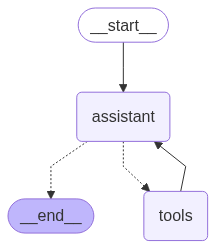

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Create the graph
builder = StateGraph(AgentState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()
react_graph

We define a `tools` node with our list of tools. The `assistant` node is just our model with bound tools. We create a graph with `assistant` and `tools` nodes.

We add a `tools_condition` edge, which routes to `End` or to `tools` based on whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node back to the `assistant`, forming a loop.

-   After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
-   If it is a tool call, the flow is directed to the `tools` node.
-   The `tools` node connects back to `assistant`.
-   This loop continues as long as the model decides to call tools.
-   If the model response is not a tool call, the flow is directed to END, terminating the process.

## Run the System
### Example 1: Simple Calculations

In [13]:
messages = [HumanMessage(
    content="Divide 93934 by 3"
)]
messages = react_graph.invoke({
    "messages": messages, 
    "input_file": None
})

# Show the messages
for m in messages["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Divide 93934 by 3
================================== Ai Message ==================================
Tool Calls:
  divide (call_wm29jxz3)
 Call ID: call_wm29jxz3
  Args:
    a: 93934
    b: 3
================================= Tool Message =================================
Name: divide

31311.333333333332
================================== Ai Message ==================================

<think>
Okay, the user asked to divide 93934 by 3. I need to use the divide function here. Let me check the parameters: a is 93934 and b is 3. Both are integers, which fits the function's requirements. I'll call the divide function with these values. The result from the tool is 31311.333333333332. Now, I should present this answer clearly. Maybe round it to two decimal places since it's a currency or standard practice, but the user didn't specify. So I'll stick with the exact result. Let me confirm the calculation: 3 times 313

In [26]:
messages

{'input_file': None,
 'messages': [HumanMessage(content='Divide 93934 by 3', additional_kwargs={}, response_metadata={}, id='841076a8-0afe-4e0e-a6bd-84e06eb21f61'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wm29jxz3', 'function': {'arguments': '{"a":93934,"b":3}', 'name': 'divide'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 127, 'prompt_tokens': 314, 'total_tokens': 441, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3:8b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-87', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3b601d73-4e8a-41f5-9485-39945f31c85b-0', tool_calls=[{'name': 'divide', 'args': {'a': 93934, 'b': 3}, 'id': 'call_wm29jxz3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 314, 'output_tokens': 127, 'total_tokens': 441, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(co

In [27]:
len(messages)

2

In [30]:
type(messages)

langgraph.pregel.io.AddableValuesDict

## Example 2: Analyze Documents

In [31]:
messages = [
    HumanMessage(
        content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?"
    )
]
messages = react_graph.invoke(
    {
        "messages": messages, 
        "input_file": "Batman_training_and_meals.png"
    }
)
for m in messages["messages"]: 
    m.pretty_print()

Error extracting text: 'utf-8' codec can't decode byte 0x82 in position 8: invalid start byte
================================ Human Message =================================

According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_mat1br5e)
 Call ID: call_mat1br5e
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text


================================== Ai Message ==================================

<think>
Okay, the user asked about the list of items to buy for the dinner menu from Mr. Wayne's note in the provided image. I called the extract_text function on the image file "Batman_training_and_meals.png". Now, I need to process the response from that function.

Wait, the tool response came back with the ex

In [23]:
messages

{'input_file': 'Batman_training_and_meals.png',
 'messages': [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?", additional_kwargs={}, response_metadata={}, id='48c67451-3aea-4dbd-a375-13a1fe237cb4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2y1vkqyp', 'function': {'arguments': '{"img_path":"Batman_training_and_meals.png"}', 'name': 'extract_text'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 321, 'prompt_tokens': 336, 'total_tokens': 657, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen3:8b', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-358', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50ce3159-8dd1-45cf-9ec3-15d0fcd554ec-0', tool_calls=[{'name': 'extract_text', 'args': {'img_path': 'Batman_training_and_meals.png'}

## Optimized All-in-one Workflow

In [40]:
# Import libraries
import base64
import httpx
from typing import TypedDict, Optional, Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Create agent's state
class AgentState(TypedDict): 
    input_file: Optional[str] 
    messages: Annotated[list[AnyMessage], add_messages]

# Initialize VLM
vision_llm = ChatOpenAI(
    model="qwen2.5vl:7b", 
    api_key="ollama", 
    base_url="http://localhost:11434/v1"
)

# Tool: extract text
def extract_text(img_path: str) -> str: 
    """
    Extract text from an image file using a multimodal model.    
    """
    all_text = ""
    try: 
        # Read image and encode as base64
        image_base64 = base64.b64encode(httpx.get(img_path).content).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": (
                            "Extract text in the given image. Return ONLY the extracted text, no explanations."
                        )
                    }, 
                    {
                        "type": "image",
                        "source_type": "base64",
                        "data": image_base64,
                        "mime_type": "image/png",
                    }
                ]
            )
        ]

        # Call the VLM
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    
    except Exception as e: 
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

# Tool: divid two numbers    
def divide(a: int, b: int) -> float: 
    "Divide two numbers."
    return a / b

# Declare tool list
tools = [divide, extract_text]

# Initialize LLM
llm = ChatOpenAI(
    model="qwen3:8b", 
    api_key="ollama", 
    base_url="http://localhost:11434/v1"
)

# Bind tools with LLM
llm_with_tools = llm.bind_tools(
    tools, 
    parallel_tool_calls=False
)

# Node: assistant
def assistant(state: AgentState): 
    textual_description_of_tool = """
    extract_text(img_path: str) -> str:
        Extract text from an image file using a multimodal model.

        Args:
            img_path: An image file path url (strings).

        Returns:
            A single string containing the concatenated text extracted from each image.

    divide(a: int, b: int) -> float:
        Divide a and b
    """

    image = state["input_file"]
    sys_msg = SystemMessage(
        content=f"""You analyse documents and run computations with provided tools:
        {textual_description_of_tool}
        You have access to given images. Currently the loaded image is: {image}
        """
    )

    return {
        # Invoke LLM agent
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

# Create StateGraph
builder = StateGraph(AgentState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant", 
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition
)

# Add edges
builder.add_edge("tools", "assistant")

# Build StateGraph
react_graph = builder.compile()

In [29]:
# Example 1: Simple Calculations
messages = [HumanMessage(
    content="Divide 93934 by 3"
)]
messages = react_graph.invoke({
    "messages": messages, 
    "input_file": None
})

# Show the messages
for m in messages["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Divide 93934 by 3
================================== Ai Message ==================================
Tool Calls:
  divide (call_qr6gy7gw)
 Call ID: call_qr6gy7gw
  Args:
    a: 93934
    b: 3
================================= Tool Message =================================
Name: divide

31311.333333333332
================================== Ai Message ==================================

<think>
Okay, the user asked to divide 93934 by 3. I need to use the divide function here. Let me check the parameters again. The function requires 'a' and 'b' as integers. So, a is 93934 and b is 3. I'll call the divide function with these values. The result from the tool is 31311.333333333332. Now, I should present this answer clearly. Maybe round it to two decimal places since it's a currency or standard practice. Wait, the user didn't specify rounding, so perhaps I should just state the exact result. Let me confirm the cal

In [41]:
# Example 2: Analyze Documents
messages = [
    HumanMessage(
        content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?"
    )
]
messages = react_graph.invoke(
    {
        "messages": messages, 
        "input_file": "https://cdn-lfs-us-1.hf.co/repos/45/f4/45f48d5b3577034b76ee728dfe60afca3d0aa70790fda3e706eeb9276d8d5331/78e30a02cada412f2899312dfef9a6f6ba5c4cdae987305ecaeaa23565b68180?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Batman_training_and_meals.png%3B+filename%3D%22Batman_training_and_meals.png%22%3B&response-content-type=image%2Fpng&Expires=1747995911&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Nzk5NTkxMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzQ1L2Y0LzQ1ZjQ4ZDViMzU3NzAzNGI3NmVlNzI4ZGZlNjBhZmNhM2QwYWE3MDc5MGZkYTNlNzA2ZWViOTI3NmQ4ZDUzMzEvNzhlMzBhMDJjYWRhNDEyZjI4OTkzMTJkZmVmOWE2ZjZiYTVjNGNkYWU5ODczMDVlY2FlYWEyMzU2NWI2ODE4MD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG9uc2UtY29udGVudC10eXBlPSoifV19&Signature=PdiYVHKXyRXVfBgPkVgYzI6dg9ks-nNMmxY3qY7qDo23FlrO6Hy1u4KMa7h78LNIAJVcuJA%7EVHKRMVuFiMkRSePe3F3ziV2Ok3-%7Eir7lwVnHAlDKy-MhohkOtvT%7E2c180BgPGfFFz6LGeuyDYa3gPBoSDnKGGPxXv9wR9FMvNBo6L3KMar6HhUcarpc4NUDqtNkouG5Ei0acLd-pmDZGFSXqcvTg02vO9z1yn2SALUnrZLzPq%7ET02k9cuF41BI55eAJlsYcNZ-Qs8XQxv1aE7vBBxpr7Cwmba0wLl8XqtKQ0FacEssACGMdhqqjYU%7EUswAuS7tIbnb1u9okyEmaHaw__&Key-Pair-Id=K24J24Z295AEI9"
    }
)
for m in messages["messages"]: 
    m.pretty_print()

================================ Human Message =================================

According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_4cpksri3)
 Call ID: call_4cpksri3
  Args:
    img_path: https://cdn-lfs-us-1.hf.co/repos/45/f4/45f48d5b3577034b76ee728dfe60afca3d0aa70790fda3e706eeb9276d8d5331/78e30a02cada412f2899312dfef9a6f6ba5c4cdae987305ecaeaa23565b68180?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27Batman_training_and_meals.png%3B+filename%3D%22Batman_training_and_meals.png%22%3B&response-content-type=image%2Fpng&Expires=1747995911&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0Nzk5NTkxMX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzQ1L2Y0LzQ1ZjQ4ZDViMzU3NzAzNGI3NmVlNzI4ZGZlNjBhZmNhM2QwYWE3MDc5MGZkYTNlNzA2ZWViOTI3NmQ4ZDU

In [ ]:
# Example 2: Analyze Documents
messages = [
    HumanMessage(
        content="List out ingredients and steps to make a pancake."
    )
]

image_url = "https://marketplace.canva.com/EAF_asJtgSY/2/0/1131w/canva-white-minimalist-food-recipe-magazine-a4-Whc_JuMGMFU.jpg"
messages = react_graph.invoke(
    {
        "messages": messages, 
        "input_file": "https://marketplace.canva.com/EAF_asJtgSY/2/0/1131w/canva-white-minimalist-food-recipe-magazine-a4-Whc_JuMGMFU.jpg"
    }
)

for m in messages["messages"]: 
    m.pretty_print()

================================ Human Message =================================

List out ingredients and steps to make a pancake.
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_nys2fb0h)
 Call ID: call_nys2fb0h
  Args:
    img_path: https://marketplace.canva.com/EAF_asJtgSY/2/0/1131w/canva-white-minimalist-food-recipe-magazine-a4-Whc_JuMGMFU.jpg
================================= Tool Message =================================
Name: extract_text

THE PANCAKE RECIPE
Ingredients:
- 1 cup all-purpose flour
- 2 tablespoons sugar
- 2 teaspoons baking powder
- 1/2 teaspoon salt
- 1 egg
- 1 cup milk
- 1 teaspoon butter, melted
- 2 tablespoons butter, melted
- 1 tablespoon vanilla extract

Instructions:
1. In a large bowl, whisk together the flour, sugar, baking powder, and salt.
2. In a separate bowl, whisk together the milk, egg, melted butter, and vanilla extract (if using).
3. Pour the wet ingredients into the dry ingredien

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image(url=image_url))

## Key Takeaways
1.  **Define clear tools** for specific document-related tasks
2.  **Create a robust state tracker** to maintain context between tool calls
3.  **Consider error handling** for tool failures
4.  **Maintain contextual awareness** of previous interactions (ensured by the operator `add_messages`)